<a href="https://colab.research.google.com/github/gmagannaDevelop/segnet/blob/mru_tests/MultiResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiResUNet
## DCI-Net
#### Gustavo Magaña

\########################################################

In [0]:
!ls

drive  sample_data


In [0]:
!apt install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.5+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [0]:
## If changes are made to the repo, uninstall and
## a fresh pip install are required, so it seems.
#!pip uninstall segnet
!pip install git+https://github.com/gmagannaDevelop/segnet.git@mru_tests
##!pip install git+https://github.com/gmagannaDevelop/segnet.git@log_hotfix

  Cloning https://github.com/gmagannaDevelop/segnet.git (to revision mru_tests) to /tmp/pip-req-build-fimkzmju
  Running command git clone -q https://github.com/gmagannaDevelop/segnet.git /tmp/pip-req-build-fimkzmju
  Running command git checkout -b mru_tests --track origin/mru_tests
  Switched to a new branch 'mru_tests'
  Branch 'mru_tests' set up to track remote branch 'mru_tests' from 'origin'.
  Created wheel for segnet: filename=segnet-0.4-cp36-none-any.whl size=22815 sha256=1d08cd56ebe8f375489e1a8dc1ad93c96ad9f81cdc040cd9b74e110a1fe933cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jvfx9ir/wheels/f1/c1/51/0ee27f445c3a618413714a84d4f5500547456389437a85a87f
Successfully built segnet


Imports

In [0]:
### System-related
import sys
import os
import datetime 
#import importlib.util
###############################################################

### Machine learning specific
#import segmentation_models as sm
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras.models
###############################################################

### In-Out
from skimage import io
import glob
###############################################################

### Visualization
import seaborn as sns
###############################################################

### Numerical
import numpy as np
###############################################################

### Repo-specific (segnet)
from segnet.train import train_segnet
from segnet.models import multiresunet2 as mru
from segnet.utils import timing
#from segnet.segnet.train.train_segnet import train_segnet
#import segnet.segnet as segnet

### Data-related
from google.colab import drive, files
drive.mount('/content/drive/')
###############################################################


### Not an import, but mandatory to be defined here :
root_dir   = "drive/My Drive/DCI-Net"
_log_file  = os.path.join(root_dir, "time_logs.jsonl")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Function definition

In [0]:
def yield_model_name(
    architecture: str = "MultiResUNet",
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0]
  return f"{architecture}-({date}).h5"

def yield_mask_directory(
    architecture: str = "MultiResUNet",
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0].split(" ")[0]
  return f"{architecture}-({date})"

In [0]:
yield_model_name()

'MultiResUNet-(2019-11-04 01:48:44).h5'

In [0]:
yield_mask_directory()

'MultiResUNet-(2019-11-04)'

In [0]:
!ls "drive/My Drive/DCI-Net/Masks"

Sunday3nov


In [0]:
!ls "drive/My Drive/DCI-Net/Colab_data/Dataset 2"

images	masks


In [0]:
# Declare the paths to use (following the Keras convention)
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit_generator
masks_path = img_path = data_path  = "drive/My Drive/DCI-Net/Colab_data/Dataset 2"

_img_path   = os.path.join(data_path, 'imgs')
_masks_path = os.path.join(data_path, 'msks')


_model_snapshots_dir = os.path.join(root_dir, "ModelSnapshots")
_model_log_path = os.path.join(
    _model_snapshots_dir, 
    yield_model_name(architecture="MultiResUNet")
)


In [45]:
print(f"{data_path}\n {masks_path}\n {img_path}\n {_img_path}\n {_masks_path}")

drive/My Drive/DCI-Net/Colab_data/Dataset 2
 drive/My Drive/DCI-Net/Colab_data/Dataset 2
 drive/My Drive/DCI-Net/Colab_data/Dataset 2
 drive/My Drive/DCI-Net/Colab_data/Dataset 2/imgs
 drive/My Drive/DCI-Net/Colab_data/Dataset 2/msks


Define hyperparameters


In [0]:
hyper_params = dict(
    batch_size = 8,
    epochs = 50,
    steps_per_epoch=100,
    model_file = _model_log_path
)

# DEBUG COMMENT OUT WHEN TRAINING : 
_debug_hyper_params = dict(
    batch_size = 8,
    epochs = 1,
    steps_per_epoch=2,
    model_file = _model_log_path
)

Get the stored snapshots :

In [47]:
snapshots = os.listdir(_model_snapshots_dir)
snapshots

['MultiResUNet-(2019-10-29 03:29:04).h5']

Choose a snapshot to load, if so desired :

In [48]:
load_snapshot = os.path.join(_model_snapshots_dir, snapshots[0])
load_snapshot

'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2019-10-29 03:29:04).h5'

Instantiate a MultiResUNet model, **optionally** from a checkpoint :

In [0]:
model = mru.MultiResUNet()

# TOGGLE THIS !
from_checkpoint = False

if from_checkpoint:
  model.load_weights(load_snapshot)


Train the model :

In [50]:
history = train_segnet.train_segnet(
    model,
    _img_path,
    _masks_path,
    **hyper_params
)


Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Epoch 1/50
100/100 [==============================] - 38s 385ms/step - loss: 0.5367 - jaccard_index: 0.2147 - dice_coef: 0.3532

Epoch 00001: val_jaccard_index improved from -inf to 0.21475, saving model to drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2019-11-04 01:48:44).h5
100/100 [==============================] - 216s 2s/step - loss: 0.4762 - jaccard_index: 0.2687 - dice_coef: 0.4228 - val_loss: 0.5367 - val_jaccard_index: 0.2147 - val_dice_coef: 0.3532
Epoch 2/50
100/100 [==============================] - 25s 247ms/step - loss: 0.4851 - jaccard_index: 0.1937 - dice_coef: 0.3240

Epoch 00002: val_jaccard_index did not improve from 0.21475
100/100 [==============================] - 126s 1s/step - loss: 0.4377 - jaccard_index: 0.2805 - dice_coef: 0.4377 - val_loss: 0.4851 - val_jaccard_index: 0.1937 - val_dice_coef: 0.3

In [51]:
print(_masks_path)

drive/My Drive/DCI-Net/Colab_data/Dataset 2/msks


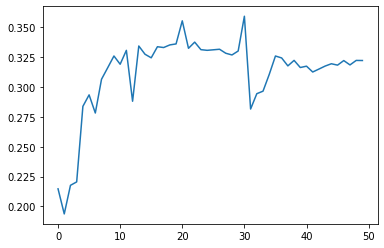

In [52]:
_jaccard = history.history['val_jaccard_index']
sns.lineplot(list(range(len(_jaccard))), _jaccard)

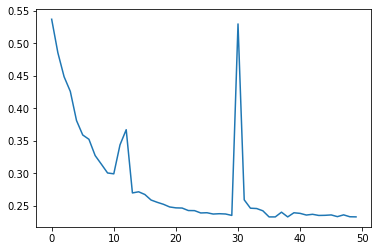

In [53]:
_loss = history.history['val_loss']
sns.lineplot(list(range(len(_loss))), _loss)

In [0]:
_img_path   = os.path.join(data_path, 'images')
_masks_path = os.path.join(data_path, 'masks')

In [0]:
model.predict()

In [0]:
!ls "drive/My Drive/DCI-Net/Colab_data/Dataset 1/images/"

 001.bmp        048.bmp       '094 (2).bmp'   142.bmp   195.bmp   248.bmp
 002.bmp        049.bmp       '094 (3).bmp'   143.bmp   196.bmp   249.bmp
 003.bmp        050.bmp       '094 (4).bmp'   144.bmp   197.bmp   250.bmp
 004.bmp        051.bmp       '094 (5).bmp'   145.bmp   198.bmp   251.bmp
 005.bmp        052.bmp       '094 (6).bmp'   146.bmp   199.bmp   252.bmp
 006.bmp        053.bmp        094.bmp	      147.bmp   200.bmp   253.bmp
 007.bmp        054.bmp        095.bmp	      148.bmp   201.bmp   254.bmp
 008.bmp        055.bmp        096.bmp	      149.bmp   202.bmp   255.bmp
 009.bmp        056.bmp        097.bmp	      150.bmp   203.bmp   256.bmp
 010.bmp       '057 (1).bmp'   098.bmp	      151.bmp   204.bmp   257.bmp
 011.bmp       '057 (2).bmp'   099.bmp	      152.bmp   205.bmp   258.bmp
 012.bmp        057.bmp        100.bmp	      153.bmp   206.bmp   259.bmp
 013.bmp        058.bmp        101.bmp	      154.bmp   207.bmp   260.bmp
 014.bmp        059.bmp        102.bmp	      1

In [0]:
list(range(5))

[0, 1, 2, 3, 4]

In [0]:
files.download("/time_logs.jsonl")

FileNotFoundError: ignored

In [0]:
os.listdir(".")

['.config', 'time_logs.jsonl', 'drive', 'sample_data']

In [0]:
files.download("time_logs.jsonl")

MessageError: ignored

In [0]:
!ls

sample_data


In [0]:
cp "time_logs.jsonl" "drive/My Drive/DCI-Net"

cp: cannot stat 'time_logs.jsonl': No such file or directory


In [0]:
!cat time_logs.jsonl | jq

{
  "datetimeUTC": "2019-10-28 20:46:23.879399",
  "function": "train_segnet",
  "args": [
    "<class 'tensorflow.python.keras.engine.training.Model'>",
    "drive/My Drive/DCI-Net/Colab_data/Dataset 1",
    "drive/My Drive/DCI-Net/Colab_data/Dataset 1"
  ],
  "kwargs": {
    "batch_size": 8,
    "epochs": 50,
    "steps_per_epoch": 100,
    "model_file": "drive/My Drive/DCI-Net/second_mutlires_gpu_WBC.h5"
  },
  "time": 7054.45720076561
}


In [0]:
# 1 validación 5 pliegues
def 

In [0]:
@timing.time_log(path_to_logfile=_log_file)
def _dummy_debug_function(*args, **kw):
  pass
  

In [0]:
log

NameError: ignored

In [0]:
_dummy_debug_function(5, '234', 5.2, hola='pass', foo='bar')